In [3]:
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

In [ ]:
marker_dict = {9: "left_wrist", 10: "right_wrist", 
                15: "left_ankle", 16: "right_ankle", 
                }   # 11: "left_hip",12: "right_hip"

config_hand1 = {"a": 60, "b": 140, "sub_dir": "hand", "markerA_id": [9, 10], 
                "modes": ["zero_uni", "zero_bi"], "metric": ["pos", "vel"]}

config_foot1 = {"a": 60, "b": 140, "sub_dir": "foot", "markerA_id": [15, 16], 
                "modes": ["zero_uni", "zero_bi"], "metric": ["pos", "vel"]}


tol = 6
tol_type = "rel"        # rel: relative, abs" absolute
configs = [config_hand1, config_foot1]

for cfg in configs:
    a = cfg["a"]
    b = cfg["b"]
    sub_dir = cfg["sub_dir"]
    for markerA_id in cfg["markerA_id"]:
        for mode in cfg["modes"]:
            for metric in cfg["metric"]:
                
                read_path = f"./one_sensor/tempo_{a}_{b}/{metric}/{sub_dir}/{marker_dict[markerA_id]}_{mode}_{a}_{b}.pkl"
                save_path = f'./one_sensor/tempo_{a}_{b}/{metric}/score/{sub_dir}/{marker_dict[markerA_id]}_{mode}_{a}_{b}_score.pkl'
                calc_score(mode, read_path, save_path, tol_type, tol)

#### New Update March 12

In [8]:
def calculate_metrics(ref, calculated, tol_type="abs", tolerance=5, mode = "one"):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Now, 'calculated' is a list of tuples, each containing two candidate BPM values.
    For each index, we select the candidate BPM that is closest to the ground truth.
    
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (list of tuple): Each tuple contains two candidate BPMs.
        tol_type (str): "abs" or "rel" tolerance type.
        tolerance (float): Tolerance value.
        
    Returns:
        dict: Dictionary with accuracy and error metrics.
    """
    # Determine the tolerance for comparison
    if tol_type == "rel":
        ref_tolerance = ref * (tolerance / 100)
    elif tol_type == "abs":
        ref_tolerance = tolerance

    if mode == "many":
        # For each index, choose the candidate BPM that minimizes the error from ref[i]
        chosen = np.array([
            min(cand, key=lambda bpm: abs(bpm - ref[i]))
            for i, cand in enumerate(calculated)
        ])
    
    elif mode == "one":
        chosen = calculated
    
    # Compute accuracy metrics using the chosen BPMs
    acc1_count = np.sum(np.abs(chosen - ref) <= ref_tolerance)
    acc2_count = np.sum(
        (np.abs(chosen - ref) <= ref_tolerance) |
        (np.abs(chosen - 2 * ref) <= ref_tolerance) |
        (np.abs(chosen - ref / 2) <= ref_tolerance)
    )
    
    scales = [1, 2, 0.5, 3, 1/3]
    acc3_count = np.sum(np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0))
    
    hits_idx = np.where(np.abs(chosen - ref) <= ref_tolerance)[0]
    hits_dbl_idx = np.where(np.abs(chosen - 2 * ref) <= ref_tolerance)[0]
    hits_hf_idx = np.where(np.abs(chosen - ref / 2) <= ref_tolerance)[0]
    
    bpm_hits_idx = chosen[hits_idx]
    bpm_hits_dbl_idx = chosen[hits_dbl_idx]
    bpm_hits_hf_idx = chosen[hits_hf_idx]
    
    base_tempo = ref[hits_idx]
    
    # Overestimated errors:
    oe1_count = np.sum(
        (chosen > ref) &
        ~np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    oe2_count = np.sum(
        (chosen > ref) &
        np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    
    total = len(ref)
    
    metrics = {
        "acc1": (acc1_count / total) * 100,
        "acc2": (acc2_count / total) * 100,
        "acc3": (acc3_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
        "base_tempo": base_tempo,
        "hits_idx": hits_idx,
        "hits_dbl_idx": hits_dbl_idx,
        "hits_hf_idx": hits_hf_idx,
        "bpm_hits_idx": bpm_hits_idx,
        "bpm_hits_dbl_idx": bpm_hits_dbl_idx,
        "bpm_hits_hf_idx": bpm_hits_hf_idx
    }
    return metrics

#### Multi bpm

In [ ]:
def estimate_tempo_pair(a, b, mode ):

    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # bpm_pair1 35 % | bpm_pair2 55%
        ("both_hand_y", "both_foot_y"),                     # bpm_pair1 70 % | bpm_pair2 81%
        ("both_hand_resultant", "both_foot_resultant"),     # bpm_pair1 49 % | bpm_pair2 66%
        ("bothhand_xy", "bothfoot_xy"),                     # bpm_pair1 55 % | bpm_pair2 68%
        ]

    json_data = {"both_hand_foot_x": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_y": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_resultant": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_xy": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, }
    
    for hnd, ft in segment_pairs:

        read_file1 = f"./one_sensor/tempo_{a}_{b}/pos/{hnd}_{mode}_{a}_{b}.pkl"
        read_file2 = f"./one_sensor/tempo_{a}_{b}/pos/{ft}_{mode}_{a}_{b}.pkl"

        read_file3 = f"./one_sensor/tempo_{a}_{b}/vel/{hnd}_{mode}_{a}_{b}.pkl"
        read_file4 = f"./one_sensor/tempo_{a}_{b}/vel/{ft}_{mode}_{a}_{b}.pkl"

        df1 = pd.read_pickle(read_file1)
        df2 = pd.read_pickle(read_file2)
        df3 = pd.read_pickle(read_file3)
        df4 = pd.read_pickle(read_file4)

        bpm_pair = []
        bpm_quad = []
        for n in range(df1.shape[0]):
            bpm1 = df1.iloc[n]["bpm_median"]    # hand bpm
            bpm2 = df2.iloc[n]["bpm_median"]    # foot bpm
            
            bpm3 = df3.iloc[n]["bpm_median"]    # hand bpm
            bpm4 = df4.iloc[n]["bpm_median"]    # foot bpm
            
            bpm_pair.append((bpm1, bpm2))
            bpm_quad.append((bpm1, bpm2, bpm3, bpm4))
            
        ref = df1["music_tempo"].to_numpy()
        
        metrics1 = calculate_metrics(ref, bpm_pair, tol_type = "rel", tolerance = 6, mode = "many")
        metrics2 = calculate_metrics(ref, bpm_quad, tol_type = "rel", tolerance = 6, mode = "many")
        
        print(f"{hnd} | {ft}:", round(metrics1["acc1"]), round(metrics2["acc1"]))
    
    return    

tempo_cases = {
    
}


both_hand_x | both_foot_x: 35 55
both_hand_y | both_foot_y: 70 82
both_hand_resultant | both_foot_resultant: 49 67
bothhand_xy | bothfoot_xy: 55 69


### One bpm

In [ ]:
segment_keys = [
                "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                "bothhand_xy", "bothfoot_xy","both_hand_resultant", "both_foot_resultant",
                
                "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
               
                "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                 
                "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                ] 

for idx, f_name in enumerate(segment_keys):
    f_path = f"./one_sensor/tempo_{a}_{b}/pos/{f_name}_{mode}_{a}_{b}.pkl"
    df_ax = pd.read_pickle(f_path)
    
    ref = df_ax["music_tempo"].to_numpy()
    metrics = calculate_metrics(ref, np.asarray(df_ax["bpm_median"]), tol_type = "rel", tolerance = 6, mode = "one")
    print(f"{f_name}:", round(metrics["acc1"]))
    
    if (idx+1)%4 == 0:
        print("\n")

### Plot Window Cases

In [9]:
def estimate_tempo_pair(a, b, mode, w_sec, h_sec):
    # Define the segment pairs to process
    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # Example: bpm_pair ~35%, bpm_quad ~55%
        ("both_hand_y", "both_foot_y"),                     # Example: bpm_pair ~70%, bpm_quad ~81%
        ("both_hand_resultant", "both_foot_resultant"),     # Example: bpm_pair ~49%, bpm_quad ~66%
        ("bothhand_xy", "bothfoot_xy"),                     # Example: bpm_pair ~55%, bpm_quad ~68%
    ]
    
    # Prepare a dictionary to hold results for each segment pair
    json_data = {}
    
    # f"{seg_key}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    
    for hnd, ft in segment_pairs:
        # Build file paths for position and velocity data
        read_file1 = f"./saved_result/window_cases/pos/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file2 = f"./saved_result/window_cases/pos/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file3 = f"./saved_result/window_cases/vel/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file4 = f"./saved_result/window_cases/vel/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        
        # Load the dataframes
        df1 = pd.read_pickle(read_file1)
        df2 = pd.read_pickle(read_file2)
        df3 = pd.read_pickle(read_file3)
        df4 = pd.read_pickle(read_file4)
        
        # Build candidate BPM pairs (for positions) and quads (for positions and velocities)
        bpm_pair = []
        bpm_quad = []
        for n in range(df1.shape[0]):
            bpm1 = df1.iloc[n]["bpm_median"]   # hand (position)
            bpm2 = df2.iloc[n]["bpm_median"]   # foot (position)
            bpm3 = df3.iloc[n]["bpm_median"]   # hand (velocity)
            bpm4 = df4.iloc[n]["bpm_median"]   # foot (velocity)
            bpm_pair.append((bpm1, bpm2))
            bpm_quad.append((bpm1, bpm2, bpm3, bpm4))
        
        # Use music_tempo from df1 as the reference tempo array.
        ref = df1["music_tempo"].to_numpy()
        
        # Calculate metrics for the candidate pairs and quads
        metrics1 = calculate_metrics(ref, bpm_pair, tol_type="rel", tolerance=6, mode = "many")
        metrics2 = calculate_metrics(ref, bpm_quad, tol_type="rel", tolerance=6, mode = "many")
        
        # For clarity, build a key for the current segment pair
        pair_key = f"{hnd}_{ft}"
        
        # Print the Acc1 results for each candidate method
        # print(f"{pair_key}: Acc1 pair = {round(metrics1['acc1'])}%, Acc1 quad = {round(metrics2['acc1'])}%")
        
        # Store the candidate BPMs and accuracy metrics in json_data
        json_data[pair_key] = {
            "bpm_pair": bpm_pair,
            "bpm_quad": bpm_quad,
            "Acc1_bpm_pair": metrics1["acc1"],
            "Acc1_bpm_quad": metrics2["acc1"]
        }
    
    return json_data

pair_keys = ['both_hand_x_both_foot_x', 'both_hand_y_both_foot_y', 
             'both_hand_resultant_both_foot_resultant', 'bothhand_xy_bothfoot_xy']
a = 60; b= 140
mode = "zero_uni"
w_sec_list = np.arange(1,14).tolist()

wcase_data = {
    key: {
        "w_sec": [],
        "h_sec": [],
        "Acc1_bpm_pair": [],
        "Acc1_bpm_quad": []
    }
    for key in pair_keys
}

for w_sec in w_sec_list:
    for fraction in [0.25, 0.5, 0.75, 1]:
        h_sec = w_sec * fraction
        jdata = estimate_tempo_pair(a, b, mode, w_sec, h_sec)
        for ky, itm in jdata.items():
            wcase_data[ky]["w_sec"].append(w_sec)
            wcase_data[ky]["h_sec"].append(fraction)
            wcase_data[ky]["Acc1_bpm_pair"].append(itm["Acc1_bpm_pair"])
            wcase_data[ky]["Acc1_bpm_quad"].append(itm["Acc1_bpm_quad"])
        

In [10]:
df_result = pd.DataFrame(wcase_data['both_hand_y_both_foot_y'])
df_result

,w_sec,h_sec,Acc1_bpm_pair,Acc1_bpm_quad
0,1,0.25,27.964206,42.132737
1,1,0.50,27.367636,40.715884
2,1,0.75,28.486204,43.102163
3,1,1.00,24.459359,38.478747
4,2,0.25,63.907532,76.510067
5,2,0.50,60.551827,75.167785
6,2,0.75,58.165548,73.601790
7,2,1.00,58.165548,72.557793
8,3,0.25,68.158091,80.536913
9,3,0.50,66.666667,79.642058


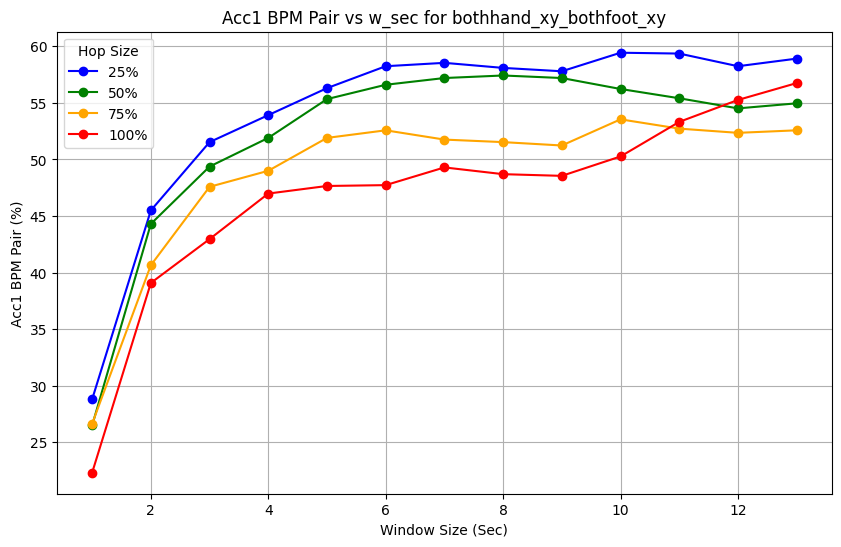

In [ ]:
# Define a color mapping for each hop size factor.
# These values correspond to the multipliers: 0.25, 0.5, 0.75, and 1.0.
color_map = {
    0.25: "blue",
    0.5: "green",
    0.75: "orange",
    1.0: "red"
}
pair_keys = ['both_hand_x_both_foot_x', 'both_hand_y_both_foot_y', 
             'both_hand_resultant_both_foot_resultant', 'bothhand_xy_bothfoot_xy']
# Choose a segment key, for example:
segment_key = pair_keys[3]

# Convert the corresponding dictionary to a DataFrame.
df_seg = pd.DataFrame(wcase_data[segment_key])

plt.figure(figsize=(10, 6))

# Loop over each unique h_sec value and plot Acc1 vs. w_sec.
for h in sorted(df_seg["h_sec"].unique()):
    # Filter rows for this hop size
    df_h = df_seg[df_seg["h_sec"] == h]
    # Plot: x-axis = w_sec, y-axis = Acc1_bpm_pair
    plt.plot(df_h["w_sec"], df_h["Acc1_bpm_pair"],
             marker="o", 
             label=f"{int(h*100)}%", 
             color=color_map.get(round(h, 2), "black"))
    
plt.xlabel("Window Size (Sec)")
plt.ylabel("Acc1 BPM Pair (%)")
plt.title(f"Acc1 BPM Pair vs w_sec for {segment_key}")
plt.legend(title="Hop Size")
plt.grid(True)
plt.show()


### Window cases Single

In [ ]:
def estimate_tempo_one(a, b, mode, w_sec, h_sec):

    segment_keys = [
                    "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                    "bothhand_xy", "bothfoot_xy",   # x onsets + y onsets
                    "both_hand_resultant", "both_foot_resultant", # resultant of x and y onsets
                    
                    "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
                
                    "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                    "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                    
                    "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                    ] 

    json_data = {}
    for idx, f_name in enumerate(segment_keys):
        f_path = f"./saved_result/window_cases/pos/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        df_ax = pd.read_pickle(f_path)
        
        ref = df_ax["music_tempo"].to_numpy()
        metrics = calculate_metrics(ref, np.asarray(df_ax["bpm_median"]), tol_type = "rel", tolerance = 6, mode = "one")
        
        json_data[f_name] = {
            "Acc1_bpm_one": metrics["acc1"],
        }
    
    return json_data

In [ ]:
segment_keys = [
                "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",   # singular
                
                "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",   # singular
                
                "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                
                "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
                "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                
                "bothhand_xy", "bothfoot_xy",
                "both_hand_resultant", "both_foot_resultant", 
                ] 

a = 60; b= 140
mode = "zero_uni"
w_sec_list = np.arange(1,14).tolist()
# h_sec = w_sec/2

wcase_data_one = {
    key: {
        "w_sec": [],
        "h_sec": [],
        "Acc1_bpm_one": [],
    }
    for key in segment_keys
}

for w_sec in w_sec_list:
    for fraction in [0.25, 0.5, 0.75, 1]:
        h_sec = w_sec * fraction
        jdata = estimate_tempo_one(a, b, mode, w_sec, h_sec)
    
    for ky, itm in jdata.items():
        wcase_data_one[ky]["w_sec"].append(w_sec)
        wcase_data_one[ky]["h_sec"].append(fraction)
        wcase_data_one[ky]["Acc1_bpm_one"].append(itm["Acc1_bpm_one"])


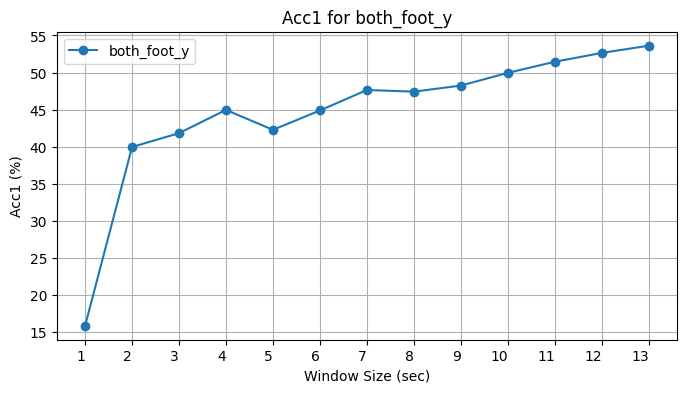

In [ ]:
## Independent Axis plot for hand and foot for tempo 60-140




def plot_acc1_for_key(key, x_positions, xaxis, tcase_data_one):
    ydata = tcase_data_one[key]["Acc1_bpm_one"]
    plt.figure(figsize=(8, 4))
    plt.plot(x_positions, ydata, marker='o', label=key)
    plt.xlabel("Window Size (sec)")
    plt.ylabel("Acc1 (%)")
    plt.title(f"Acc1 for {key}")
    plt.xticks(x_positions, xaxis, ha='right')
    plt.legend()
    plt.grid(True)
    plt.show()

# For example, to plot for one key:
key_to_plot = 'both_foot_y'  # or any key from your dictionary
plot_acc1_for_key(key_to_plot, w_sec_list, w_sec_list, wcase_data_one)